In [48]:
%load_ext autoreload
%autoreload 2
from input_reading import to_corr_matrix,to_matrix

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf as acf
import xgboost as xgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
df_train = pd.read_csv('train.csv')
# df_train.to_parquet('train.parquet')

In [11]:
# df_train = pd.read_parquet('train.parquet')

In [10]:

Points = df_train.columns.str.extract(r'(\w\d\w)\d{1,4}')[0].unique()[1:]
cross_names = [Points[i]+'x'+Points[j] for i in range(24) for j in range(i+1,24)]
len(cross_names)

276

276

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer as mk_transformer, make_column_selector as select
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder


def to_corr_features(features):
    '''transforms a df row into a df row of correlations'''
    upper_triangular_idx = np.triu_indices(24, k=1)

    cor_mat = features\
                .apply(to_corr_matrix, axis=1)\
                .apply(lambda x: x[upper_triangular_idx])\
                .values

    return pd.DataFrame(np.vstack(cor_mat), columns = cross_names)


X = to_corr_features(df_train.iloc[:,5:])

## Baseline correlation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, df_train.y, test_size=0.3)

from sklearn.svm import SVC, LinearSVC
from sklearn.impute import SimpleImputer, KNNImputer

model = SVC(class_weight='balanced')

model.fit(X_train, y_train)

SVC(class_weight='balanced')

0.3333333333333333

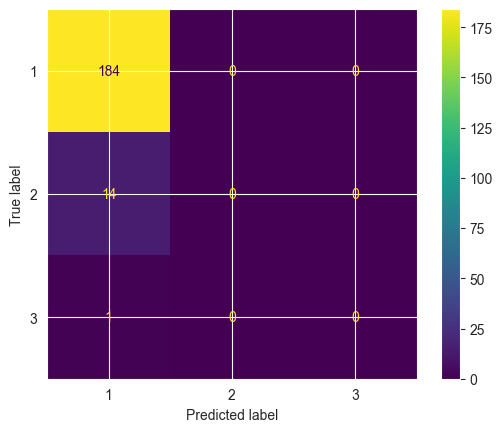

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
sns.set_style('darkgrid')
y_hat = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
balanced_accuracy_score(y_test, y_hat)

In [14]:
acf(X[0,0,:],nlags=30).shape

NameError: name 'acf' is not defined

## Population summaries

In [49]:
x = df_train.iloc[1,5:]

x.values.reshape(24,2048)

summaries = [
    np.max,
    np.min,
    np.mean,
    lambda x:np.quantile(x, q=0.05),
    lambda x: np.quantile(x,q=0.25),
    lambda x: np.quantile(x,q=0.75),
    lambda x:np.quantile(x,q=0.5),
    lambda x: np.quantile(x,q=0.95),
    np.std
]

summaries_1=[lambda x:acf(x,nlags=50)]

X = df_train.iloc[:,5:].values.reshape(663,24,2048)
X_1 = [np.concatenate([np.apply_along_axis(i,1,row) for i in summaries]) for row in X]
X_2= [np.concatenate(tuple([np.apply_along_axis(i,1,row).reshape(-1) for i in summaries_1]),axis=0) for row in X]
X=np.concatenate((X_1,X_2),axis=1)


In [15]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
#y_hat = model.predict(x_test)
#confusion_matrix(y_test,y_hat),balanced_accuracy_score(y_test, y_hat), y_test.mean()

## Cross-validation

In [16]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [19]:
d=hp.quniform('min_child_weight', 0, 10, 1)


In [21]:
df_train.y=df_train.y-1

In [22]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=df_train.y
)

In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = xgb.XGBClassifier(objective='multi:softmax',num_class=3)

skf = StratifiedKFold(n_splits=4)

In [24]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=df_train.y


)

In [87]:
space ={'max_depth': hp.uniform("max_depth", 3, 18),
        'gamma':hp.uniform('gamma',0,9),
        'eta':hp.choice('eta',[0.01,0.05,0.1,0.3]),
        'reg_alpha' : hp.choice('reg_alpha',[0.1,1,10,40,100]),
        'reg_lambda' : hp.uniform('reg_lambda',0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree',0.5,1),
        'min_child_weight' :hp.uniform('min_child_weight', 0, 10),
        #'max_delta_step':hp.choice('max_delta_step',[1,2]),
        'n_estimators': hp.choice('n_estimators',[20,40,80,100,150]),

        'seed': 0,
        'sample_weight':classes_weights
    }

In [88]:
def objective(space):

    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],eta=space['eta'],
                    reg_alpha = int(space['reg_alpha']),reg_lambda = int(space['reg_lambda']),min_child_weight=int(space['min_child_weight']),#max_delta_step=int(space['max_delta_step']),
                    colsample_bytree=int(space['colsample_bytree']))
    score=[]
    for i,(train_index,val_index) in enumerate(skf.split(X,df_train.y)):
        classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=df_train.y.iloc[train_index])

        evaluation = [( X[train_index],df_train.y.iloc[train_index]), (  X[val_index],df_train.y.iloc[val_index])]

        clf.fit(X[train_index],df_train.y.iloc[train_index],
                eval_set=evaluation, eval_metric="auc",sample_weight=classes_weights,
                early_stopping_rounds=10,verbose=False)


        pred = clf.predict(X[val_index])
        accuracy = balanced_accuracy_score(df_train.y.iloc[val_index], pred)
        score.append(accuracy)



    print ("SCORE:", np.mean(score))
    return {'loss': -np.mean(score), 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 300,
                        trials = trials)

In [90]:
best_hyperparams


{'colsample_bytree': 0.5687160748982475,
 'eta': 1,
 'gamma': 0.9204706583972477,
 'max_depth': 5.98622985705249,
 'min_child_weight': 5.643111210136509,
 'n_estimators': 0,
 'reg_alpha': 3,
 'reg_lambda': 0.12507175895842523}

In [98]:
space=best_hyperparams
clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],eta=space['eta'],
                    reg_alpha = int(space['reg_alpha']),reg_lambda = int(space['reg_lambda']),min_child_weight=int(space['min_child_weight']),#max_delta_step=int(space['max_delta_step']),
                    colsample_bytree=int(space['colsample_bytree']))
score=[]
for i,(train_index,val_index) in enumerate(skf.split(X,df_train.y)):
    classes_weights = class_weight.compute_sample_weight(
class_weight='balanced',
y=df_train.y.iloc[train_index])

    evaluation = [( X[train_index],df_train.y.iloc[train_index]), (  X[val_index],df_train.y.iloc[val_index])]

    clf.fit(X[train_index],df_train.y.iloc[train_index],
            eval_set=evaluation, eval_metric="auc",sample_weight=classes_weights,
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(X[val_index])
    accuracy = balanced_accuracy_score(df_train.y.iloc[val_index], pred)
    score.append(accuracy)



print ("SCORE:", np.mean(score))

C:\Users\matti\miniconda3\envs\Hacka\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\matti\miniconda3\envs\Hacka\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\matti\miniconda3\envs\Hacka\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\matti\miniconda3\envs\Hacka\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` 

SCORE: 0.3333333333333333


C:\Users\matti\miniconda3\envs\Hacka\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\matti\miniconda3\envs\Hacka\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [96]:
space[list(space.keys())[-1]]

0.12507175895842523

In [78]:
list(space.keys())[-1]

'reg_lamda'

In [149]:
np.arange( 0, 10, 5)

array([0, 5])

In [152]:
cv = GridSearchCV(model, param_grid=params, scoring='balanced_accuracy', n_jobs=10, cv=skf.split(X, df_train.y))
print(cv.fit(X,df_train.y).best_params_)
print(cv.best_score_)                               

In [138]:
cv.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [84]:
y_hat = cv.predict(X)
confusion_matrix(df_train.y, y_hat),balanced_accuracy_score(df_train.y, y_hat)

(array([[402, 213,   5],
        [  5,  34,   0],
        [  0,   0,   4]], dtype=int64),
 0.8400606561896885)

In [38]:
y_hat[y_hat == 3]

array([3, 3, 3, 3, 3, 3], dtype=int64)

# Submission

In [47]:
model_final = SVC(C=0.5142857142857142, class_weight='balanced', kernel='rbf')
model_final.fit(X, df_train.y)

SVC(C=1.7571428571428571, class_weight='balanced', kernel='poly')

In [85]:
df_sub = pd.read_csv('test.csv')

In [86]:
X_sub = df_sub.iloc[:,4:].values.reshape(355,24,2048)
X_sub_1 = [np.concatenate([np.apply_along_axis(i,1,row) for i in summaries]) for row in X_sub]

X_sub_2= [np.concatenate(tuple([np.apply_along_axis(i,1,row).reshape(-1) for i in summaries_1]),axis=0) for row in X_sub]
X_sub=np.concatenate((X_sub_1,X_sub_2),axis=1)


In [87]:
y_sub = cv.predict(X_sub)
submission_df = pd.DataFrame(y_sub,columns=['y'])
submission_df['id'] = df_sub.id
submission_df.set_index('id', inplace=True)
#submission_df.y = 2-submission_df.y
submission_df.to_csv('submission.csv')

In [88]:
submission_df.y.value_counts()

1    221
2    130
3      4
Name: y, dtype: int64